# Compare Energies with Different Methods
We have a database computed with TTM, DFT and MP2. Let's see how they compare

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from collections import defaultdict
from ase.db import connect
from ase.io.xyz import simple_write_xyz
from ase import units
from io import StringIO
import pandas as pd
import numpy as np

In [2]:
simple_write_xyz

<function ase.io.xyz.write_xyz(fileobj, images, comment='', fmt='%22.15f')>

## Load in the Data
Get the data from the different databases, combine them into a single dataframe

In [3]:
def load_database_to_pandas(path: str, name: str) -> pd.DataFrame:
    """Read an ASE database to a Pandas dataframe
    
    Args:
        path: Path to the ASE databases
    Returns:
        Dataframe with the filename as the key
    """
    with connect(path) as db:
        results = defaultdict(list)
        for row in db.select(""):
            if 'method' in row:
                method = f'{row["method"]}//{row["basis"]}'
            elif 'basis' in row:
                method = f'{name}//{row["basis"]}'
            else: 
                method = name
                
            
            xyz_fp = StringIO()
            simple_write_xyz(xyz_fp, [row.toatoms()])
                
            results[method].append({'filename': row['filename'],
                                    'xyz': xyz_fp.getvalue(),
                                    'n_waters': int(row.natoms // 3),
                                    f'runtime_{method}': row['runtime'],
                                    f'energy_{method}': row['energy'],
                                    f'energy_per_water_{method}': row['energy'] / int(row.natoms) * 3})
    
    # Turn them into dataframes
    data = pd.concat([
        pd.DataFrame(v).set_index('filename') for v in results.values()
    ], axis=1)
    return data

Drop off the hydrodb avtz energies

In [4]:
data = [
    load_database_to_pandas(path, name)
    for path, name in [
        ('initial-ttm.db', 'ttm'),
        ('initial-psi4.db', 'dft'),
        ('initial.db', 'mp2')
    ]
]
data = pd.concat(data, axis=1)

Drop duplicate columns

In [5]:
data = data.loc[:,~data.columns.duplicated()].copy()

In [6]:
data.head()

,xyz,n_waters,runtime_ttm,energy_ttm,energy_per_water_ttm,runtime_pbe0-d3//aug-cc-pvdz,energy_pbe0-d3//aug-cc-pvdz,energy_per_water_pbe0-d3//aug-cc-pvdz,runtime_pbe0//aug-cc-pvdz,energy_pbe0//aug-cc-pvdz,energy_per_water_pbe0//aug-cc-pvdz,runtime_mp2//aug-cc-pvdz,energy_mp2//aug-cc-pvdz,energy_per_water_mp2//aug-cc-pvdz,runtime_mp2//aug-cc-pvtz,energy_mp2//aug-cc-pvtz,energy_per_water_mp2//aug-cc-pvtz
filename,,,,,,,,,,,,,,,,,
hydrodb_b09a9c.xyz,33\n\nO 2.267658576179596 1.9463707...,11,0.000952,-4.317942,-0.392540,135.526126,-22861.096468,-2078.281497,118.740917,-22860.546873,-2078.231534,731.741435,-22831.040891,-2075.549172,11718.070250,-22851.387537,-2077.398867
hydrodb_19306c.xyz,45\n\nO 2.272800839227977 1.4592290...,15,0.002468,-6.437979,-0.429199,243.111790,-31174.900830,-2078.326722,230.604889,-31174.064939,-2078.270996,1868.222484,-31133.868193,-2075.591213,NaN,NaN,NaN
hydrodb_2e6378.xyz,39\n\nO -1.313802046079421 0.8735302...,13,0.001802,-5.313869,-0.408759,181.667849,-27017.892767,-2078.299444,165.599819,-27017.224435,-2078.248033,1151.305755,-26982.360610,-2075.566201,14121.422478,-27006.408247,-2077.416019
hydrodb_8f0fe1.xyz,30\n\nO 1.335199862023815 1.6184582...,10,0.001045,-3.704616,-0.370462,100.233233,-20782.646887,-2078.264689,66.421736,-20782.215710,-2078.221571,532.396499,-20755.347525,-2075.534753,5737.389443,-20773.853003,-2077.385300
mctbp_147.xyz,9\n\nO 0.190866174783793 -1.59656170...,3,0.000156,-0.211835,-0.070612,9.088620,-6233.402780,-2077.800927,8.258589,-6233.344772,-2077.781591,209.804522,-6225.171037,-2075.057012,316.685000,-6230.780832,-2076.926944


Normalize by the energy above the most-stable cluster

In [7]:
lowest_energy = data['energy_per_water_mp2//aug-cc-pvtz'].idxmin()
print(f'Using {lowest_energy} as a reference')

Using hydrodb_10a43d.xyz as a reference


In [8]:
names = [c[17:] for c in data.columns if c.startswith('energy_per_water')]

In [9]:
data[[f'energy_{n}' for n in names]].count()

energy_ttm                     1720
energy_pbe0-d3//aug-cc-pvdz    1720
energy_pbe0//aug-cc-pvdz       1720
energy_mp2//aug-cc-pvdz        1720
energy_mp2//aug-cc-pvtz         730
dtype: int64

In [10]:
for name in names:
    ref_energy = data[f'energy_per_water_{name}'][lowest_energy]
    data[f'energy_normed_{name}'] = data[f'energy_per_water_{name}'] - ref_energy
    data[f'energy_normed_{name}'] /= units.kcal / units.mol
    print(f'Reference energy for {name}: {ref_energy:.2f} eV/water')

Reference energy for ttm: -0.44 eV/water
Reference energy for pbe0-d3//aug-cc-pvdz: -2078.35 eV/water
Reference energy for pbe0//aug-cc-pvdz: -2078.29 eV/water
Reference energy for mp2//aug-cc-pvdz: -2075.61 eV/water
Reference energy for mp2//aug-cc-pvtz: -2077.46 eV/water


In [11]:
data[[c for c in data.columns if 'normed' in c]].sort_values('energy_normed_mp2//aug-cc-pvdz').head(15)

,energy_normed_ttm,energy_normed_pbe0-d3//aug-cc-pvdz,energy_normed_pbe0//aug-cc-pvdz,energy_normed_mp2//aug-cc-pvdz,energy_normed_mp2//aug-cc-pvtz
filename,,,,,
min_1930862.xyz,-0.692863,-0.729530,-0.563008,-0.704033,NaN
min_2249639.xyz,-0.726079,-0.737443,-0.609184,-0.692399,NaN
min_1933997.xyz,-0.670709,-0.689152,-0.588272,-0.653644,NaN
min_1932988.xyz,-0.676280,-0.659440,-0.435840,-0.647172,NaN
min_1943025.xyz,-0.637412,-0.647561,-0.481419,-0.629709,NaN
min_1937085.xyz,-0.656781,-0.623649,-0.475223,-0.615653,NaN
min_1948890.xyz,-0.622349,-0.626870,-0.442972,-0.605721,NaN
min_2343163.xyz,-0.572240,-0.587738,-0.423612,-0.602338,NaN
min_1982257.xyz,-0.558518,-0.627011,-0.520977,-0.595227,NaN


In [12]:
data.groupby('n_waters')['runtime_mp2//aug-cc-pvtz'].median()

n_waters
3       273.970866
4       423.033950
5       670.864447
6      1599.392593
7      2399.272860
8      3153.368628
9      4257.508402
10     5763.887559
11     8308.246604
12     9197.879248
13    13129.926815
14    15744.384384
15    66643.853312
16    79117.335418
17             NaN
18             NaN
19             NaN
20             NaN
21             NaN
22             NaN
23             NaN
24             NaN
25             NaN
Name: runtime_mp2//aug-cc-pvtz, dtype: float64

In [ ]:
data = data[data.str.

## Plot
Show how different things are between TTM and DFT

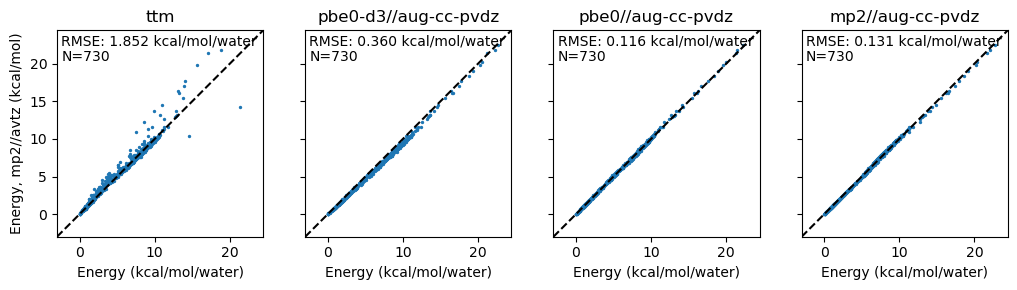

In [15]:
fig, axs = plt.subplots(1, len(names) - 1, figsize=(10.5, 3.), sharey=True)

not_avtz = [n for n in names if 'mp2//aug-cc-pvtz' not in n]
for name, ax in zip(not_avtz, axs):
    col = f'energy_normed_{name}'
    ax.scatter(data[col], data['energy_normed_mp2//aug-cc-pvtz'], s=2)
    err = (data[col] - data['energy_normed_mp2//aug-cc-pvtz']).abs()
    count = err.count()
    mae = err.mean()
    rmse = np.sqrt((err ** 2).mean())
    ax.text(0.02, 0.85, f'RMSE: {rmse:.3f} kcal/mol/water\nN={count}', transform=ax.transAxes)
    ax.set_xlabel(f'Energy (kcal/mol/water)')
    ax.set_title(name)
    
    ax.set_xlim([-3, data['energy_normed_mp2//aug-cc-pvtz'].max() + 2])
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

# Set the xlim
axs[0].set_ylabel('Energy, mp2//avtz (kcal/mol)')

fig.tight_layout()
fig.savefig('figures/comparison-to-mp2-avtz.png', dpi=320)

Save the data for others

In [14]:
data.to_csv('comparison-water-clusters.csv')